In [5]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas.plotting import lag_plot

[*********************100%***********************]  1 of 1 completed


                            OLS Regression Results                            
Dep. Variable:      1 Period % Change   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     7.571
Date:                Sat, 21 Jun 2025   Prob (F-statistic):            0.00597
Time:                        11:56:47   Log-Likelihood:                 7865.7
No. Observations:                2639   AIC:                        -1.573e+04
Df Residuals:                    2637   BIC:                        -1.572e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.739      0.0

Price,Adj Close,Close,High,Low,Open,Volume,Close + 1,1 Period % Change,High_2prev,Bull_FVG,Bull_FVG_Val,Low_2prev,Bear_FVG,Bear_FVG_Val,Both_FVG,Predictions,Residuals
2,24.605864,44.343750,44.375000,44.125000,44.218750,201300,44.812500,0.010571,43.968750,1,0.003524,43.750000,0,0.000000,0.003524,0.000159,0.010412
3,24.865974,44.812500,44.843750,44.375000,44.406250,529400,45.000000,0.004184,44.250000,1,0.002789,43.968750,0,0.000000,0.002789,0.000213,0.003971
4,24.970015,45.000000,45.093750,44.468750,44.968750,531500,44.968750,-0.000694,44.375000,1,0.002083,44.125000,0,0.000000,0.002083,0.000264,-0.000959
8,24.813965,44.718750,44.750000,44.531250,44.656250,379600,44.937500,0.004892,45.125000,0,-0.000000,44.906250,1,-0.003494,-0.003494,0.000674,0.004218
11,24.120335,43.468750,44.468750,43.406250,44.468750,374800,43.437500,-0.000719,45.125000,0,-0.000000,44.781250,1,-0.007189,-0.007189,0.000945,-0.001664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8134,581.371338,583.090027,586.619995,581.409973,582.659973,70860400,579.109985,-0.006826,594.049988,0,-0.000000,589.599976,1,-0.005111,-0.005111,0.000792,-0.007618
8135,577.403015,579.109985,581.809998,575.599976,575.979980,76029000,591.150024,0.020791,592.580017,0,-0.000000,581.820007,1,-0.000017,-0.000017,0.000419,0.020372
8137,585.997620,587.729980,592.770020,586.989990,591.559998,68445500,590.049988,0.003947,581.809998,1,0.008814,575.599976,0,0.000000,0.008814,-0.000229,0.004177
8141,594.333008,596.090027,597.080017,591.849976,592.340027,63606200,595.929993,-0.000268,591.130005,1,0.001208,583.239990,0,0.000000,0.001208,0.000329,-0.000597


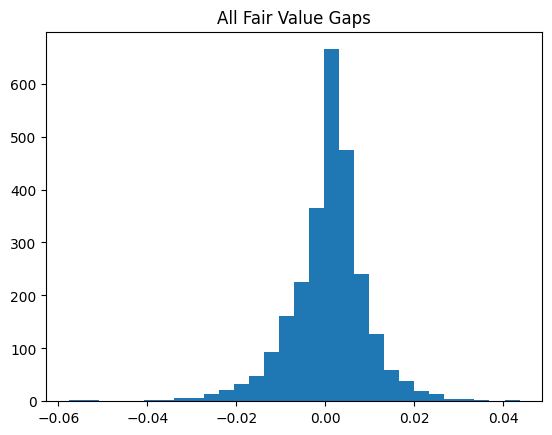

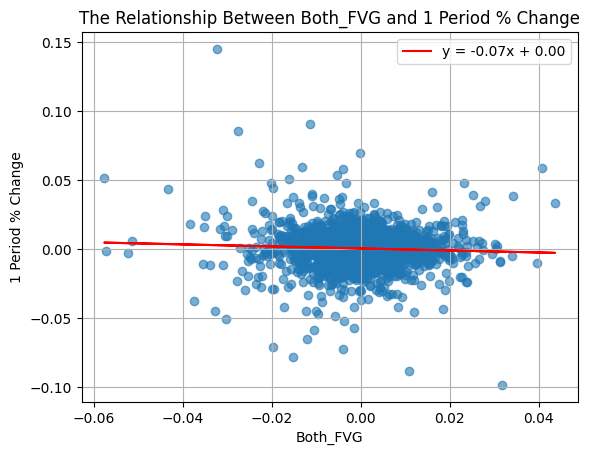

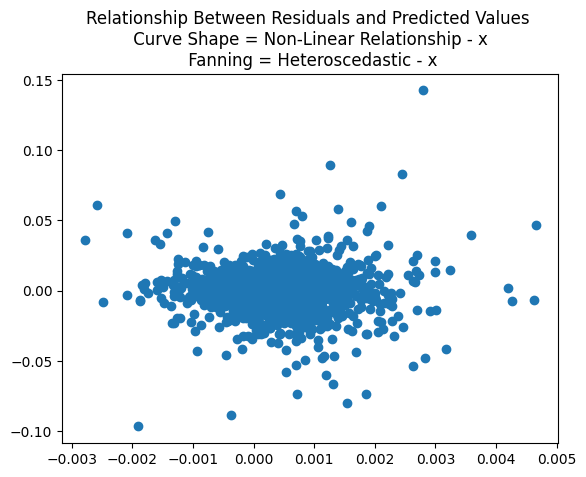

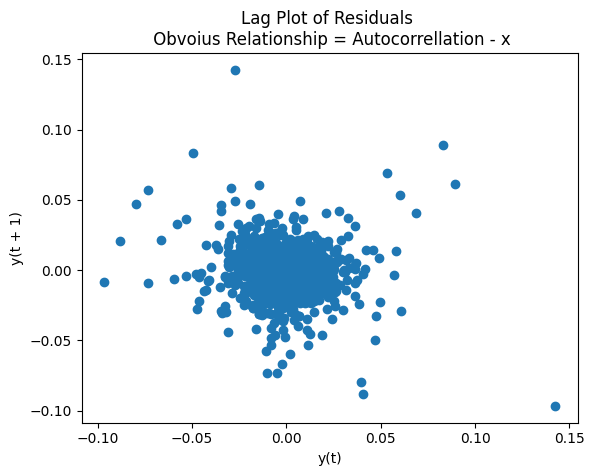

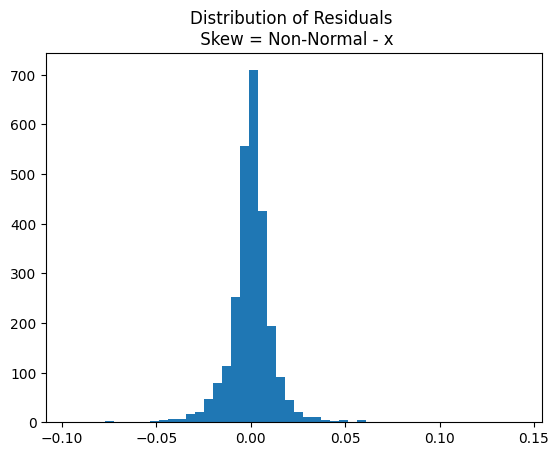

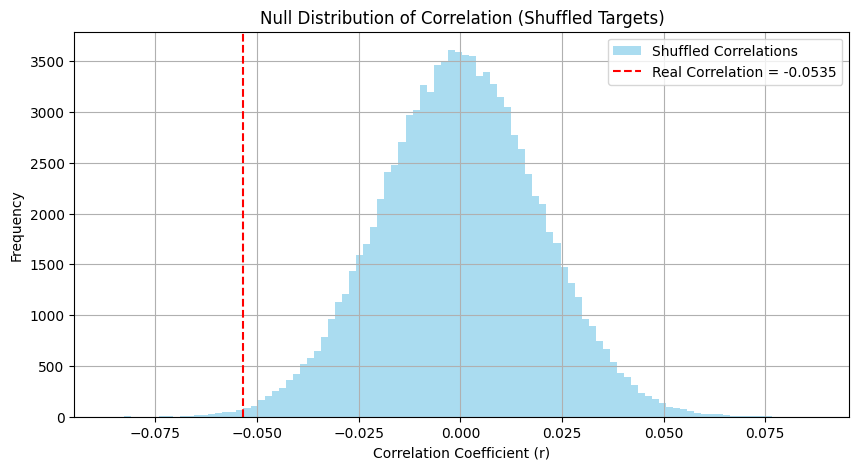

In [6]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 1
STRATEGY = 'Both_FVG'

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df[f'{shift} Period % Change'] = (df[f'Close + {shift}'] - df['Close']) / df['Close']

    return df

def bull_fvg(df):

    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    return df

def bear_fvg(df):

    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    return df

def prepare_dataframe_for_regression(df):
    df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
    df['Both_FVG'] = df['Bear_FVG_Val'] + df['Bull_FVG_Val']

    plt.figure()
    plt.hist(df['Both_FVG'], bins=30)
    plt.title('All Fair Value Gaps')

    return df

def generate_regression_output(df, features=f'{STRATEGY}', target=f'{SHIFT} Period % Change'):
    subset = df[[features, target]].dropna()

    X = subset[features]
    y = subset[target]

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    intercept = model.params['const']
    coefficient = model.params[features]
    y_pred = model.predict(X_with_const)

    # Console summary
    print(model.summary())

    # Plot
    plt.figure()
    plt.title(f'The Relationship Between {features} and {target}')
    plt.plot(X, y_pred, color='red', label=f'y = {coefficient:.2f}x + {intercept:.2f}')
    plt.scatter(X, y, alpha=0.6)
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")
    plt.legend()
    plt.grid(True)

    return df, intercept, coefficient

def validate_regression_output(df, coef, intercept):

    # information necessary
    df['Predictions'] = coef * df[f'{STRATEGY}'] + intercept
    df['Residuals'] = df[f'{SHIFT} Period % Change'] - df['Predictions'] 

    # plot for linearity/homoscedasticity
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Relationship Between Residuals and Predicted Values \n ' \
        'Curve Shape = Non-Linear Relationship - x \n ' \
        'Fanning = Heteroscedastic - x')
    
    # plot for autocorrelations
    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals \n Obvoius Relationship = Autocorrellation - x')

    # plot for normality
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('Distribution of Residuals \n Skew = Non-Normal - x')

    return df

def assess_regression_output(df, coef, features=f'{STRATEGY}', target=f'{SHIFT} Period % Change', n=100000):
    subset = df[[features, target]].dropna()
    X = subset[features]
    y = subset[target]

    real_r = np.corrcoef(X, y)[0, 1]
    correlations = []

    for _ in range(n):
        shuffled_y = np.random.permutation(y)
        r = np.corrcoef(X, shuffled_y)[0, 1]
        correlations.append(r)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.hist(correlations, bins=100, alpha=0.7, color='skyblue', label='Shuffled Correlations')
    plt.axvline(real_r, color='red', linestyle='--', label=f'Real Correlation = {real_r:.4f}')
    plt.title('Null Distribution of Correlation (Shuffled Targets)')
    plt.xlabel('Correlation Coefficient (r)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    return df

def main():
    df = get_data()
    df = add_target(df)
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = prepare_dataframe_for_regression(df)
    df, fit_intercept, fit_coefficient = generate_regression_output(df)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept)
    df = assess_regression_output(df, coef=fit_coefficient)

    return df

df = main()
df